In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import RMSprop
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from sklearn.impute import SimpleImputer

# bug de tensorflow
#disable_eager_execution()

data = pd.read_csv('dataset2.csv', sep=';', skipinitialspace=True)

# columnas no numericas son del dataframe numerico
data['Res_max_comp_kpsi'] = pd.to_numeric(data['Res_max_comp_kpsi'], errors='coerce')
data['Res_max_comp_Mpa'] = pd.to_numeric(data['Res_max_comp_Mpa'], errors='coerce')

columnas_nonum = data.select_dtypes(exclude=['number']).columns
num_data = data.drop(columns=columnas_nonum)
# tratamiento de valores nulos en los datos numericos
imputer = SimpleImputer(strategy='mean')
num_data_imputed = imputer.fit_transform(num_data)

# escalado
scaler = StandardScaler()
scaled_data_imputed = scaler.fit_transform(num_data_imputed)

print("Datos escalados e imputados:")
print(scaled_data_imputed)

Datos escalados e imputados:
[[-3.78322330e-01 -3.77317278e-01 -1.77453113e-01 -1.76660016e-01
  -5.29149723e-01 -5.29214353e-01 -1.89181061e+00]
 [-3.36354516e-01 -3.36754780e-01  7.23907255e-01  7.21692675e-01
  -4.75854776e-01 -4.75902829e-01 -1.89181061e+00]
 [-3.50343787e-01 -3.50951655e-01  4.53499145e-01  4.53820236e-01
  -3.15969936e-01 -3.15968257e-01 -1.89181061e+00]
 [-2.80397431e-01 -2.79967283e-01  7.23907255e-01  7.21692675e-01
  -3.15969936e-01 -3.15968257e-01 -1.89181061e+00]
 [-3.64333059e-01 -3.63120404e-01  7.23907255e-01  7.21692675e-01
  -3.95912356e-01 -3.95935543e-01 -1.89181061e+00]
 [-3.92311601e-01 -3.91514152e-01 -4.02793206e-01 -4.02064873e-01
  -6.35739616e-01 -6.35451086e-01 -1.89181061e+00]
 [-3.92311601e-01 -3.91514152e-01  7.23907255e-01  7.21692675e-01
  -5.29149723e-01 -5.29214353e-01 -1.89181061e+00]
 [-3.92311601e-01 -3.93542277e-01  2.73227071e-01  2.74149698e-01
  -5.82444670e-01 -5.82139562e-01 -1.89181061e+00]
 [-3.64333059e-01 -3.69204779e-01  

In [52]:
def generador(input_size): #se define el modelo generador de datos
    model = models.Sequential()
    model.add(layers.Dense(7*2))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(7*4))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(7*2))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(input_size[0], activation='sigmoid'))  # Aqui se ajusta la salida para que coincida con el número de características
    return model


def discriminador(input_size): # se define el modelo discriminador
    model = models.Sequential()

    model.add(layers.Dense(7*2, input_dim=input_size[0]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(7*4))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(7*2))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


def GAN(generador, discriminador): #se construye la estructura de la gan, utilizando las funciones antes planteadas
    discriminador.trainable = False
    model = models.Sequential([generador, discriminador])
    return model




In [53]:
def compile_models(generador, discriminador, gan, learning_rate):
    generador.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate))
    discriminador.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate))
    gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate))



In [54]:
input_size = (7,)  # numero de columnas en el dataset
batch_size = 12  # Tamaño del lote para el entrenamiento
learning_rate = 0.0002#tasa de aprendizaje




In [55]:
gen = generador(input_size)
dis = discriminador(input_size)
gan = GAN(gen, dis)
compile_models(gen, dis, gan, learning_rate)

def entrenar_gan(generador, discriminador, gan, data, epochs, batch_size):
    batch_count = data.shape[0] // batch_size
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        for _ in range(batch_count):
            #entrenamiento del discriminador con datos reales
            idx = np.random.randint(0, data.shape[0], batch_size)
            datos_reales = data[idx]

            ruido = np.random.normal(0, 1, (batch_size, 100))
            datos_generados = generador.predict(ruido)

            #entrenamiento del discriminador
            d_loss_real = discriminador.train_on_batch(datos_reales, np.ones((batch_size, 1)))
            d_loss_fake = discriminador.train_on_batch(datos_generados, np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #entrenamiento del generador
            ruido = np.random.normal(0, 1, (batch_size, 100))
            g_loss = gan.train_on_batch(ruido, np.ones((batch_size, 1)))

            #almacenar perdidas
            d_losses.append(d_loss)
            g_losses.append(g_loss)

        if epoch % 10 == 0:
            if len(d_losses) > 0 and len(g_losses) > 0:
                print(f"Epoch {epoch}, perdida_discr: {d_losses[-1]}, perdida_gen: {g_losses[-1]}")

    plt.figure()
    plt.plot(range(len(d_losses)), d_losses, label='Pérdida del Discriminador')
    plt.plot(range(len(g_losses)), g_losses, label='Pérdida del Generador')
    plt.xlabel('Iteraciones')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Evolución de las Pérdidas del Generador y el Discriminador')
    plt.show()


1/1 [==============================] - 0s 27ms/step
Epoch 0, perdida_discr: 0.8859121203422546, perdida_gen: 0.5647463202476501
1/1 [==============================] - 0s 44ms/step
Epoch 10, perdida_discr: 0.8564354777336121, perdida_gen: 0.5226650238037109
1/1 [==============================] - 0s 21ms/step
Epoch 20, perdida_discr: 1.0025081038475037, perdida_gen: 0.4626990258693695
1/1 [==============================] - 0s 22ms/step


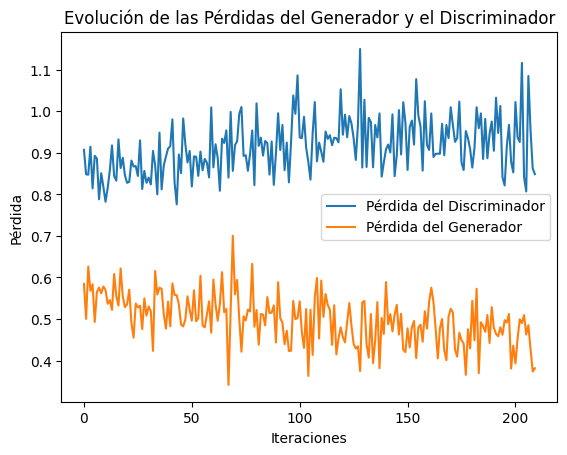

In [57]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
data = pd.read_csv('dataset2.csv', sep=';', skipinitialspace=True)

# convertir columnas a numericas
data['Res_max_comp_kpsi'] = pd.to_numeric(data['Res_max_comp_kpsi'], errors='coerce')
data['Res_max_comp_Mpa'] = pd.to_numeric(data['Res_max_comp_Mpa'], errors='coerce')
columnas_nonum = data.select_dtypes(exclude=['number']).columns
num_data = data.drop(columns=columnas_nonum)

imputer = SimpleImputer(strategy='mean')
num_data_imputed = imputer.fit_transform(num_data)

# escalado
scaler = StandardScaler()
scaled_data_imputed = scaler.fit_transform(num_data_imputed)


entrenar_gan(gen, dis, gan, scaled_data_imputed, epochs=30, batch_size=batch_size)

In [ ]:
# cantidad de muestras a generar
num_muestras = 1200
ruido = np.random.randn(num_muestras, 100)  # Generar ruido aleatorio como entrada para el generador
muestras_generadas = gen.predict(ruido)
df_datasint = pd.DataFrame(muestras_generadas, columns=num_data.columns)
df_datasint['Tipo'] = df_datasint['Tipo'].round()
data = pd.read_csv('dataset2.csv', sep=';', skipinitialspace=True)

numeric_data=data.drop("Material",axis=1)
for col in data.columns:
     data[col] = pd.to_numeric(data[col], errors='coerce')
col= numeric_data.columns.intersection(df_datasint.columns)
df_final = pd.concat([numeric_data[col], df_datasint[col]], axis=0)
df_final.to_csv('data_final.csv', index=False)
print(df_final.head())
print(muestras_generadas)

38/38 [==============================] - 0s 5ms/step
   mod_elasticidad_aproximado_Mpsi  mod_elasticidad_aproximado_Gpa  \
0                              0.3                             2.1   
1                              0.6                             4.1   
2                              0.5                             3.4   
3                              1.0                             6.9   
4                              0.4                             2.8   

   Res_max_tension_kpsi  Res_max_tension_Mpa Res_max_comp_kpsi  \
0                   6.0                 41.4              10.0   
1                  10.0                 68.9              12.0   
2                   8.8                 60.7              18.0   
3                  10.0                 68.9              18.0   
4                  10.0                 68.9              15.0   

  Res_max_comp_Mpa  Tipo  
0             68.9   0.0  
1             82.7   0.0  
2            124.1   0.0  
3            124.1   

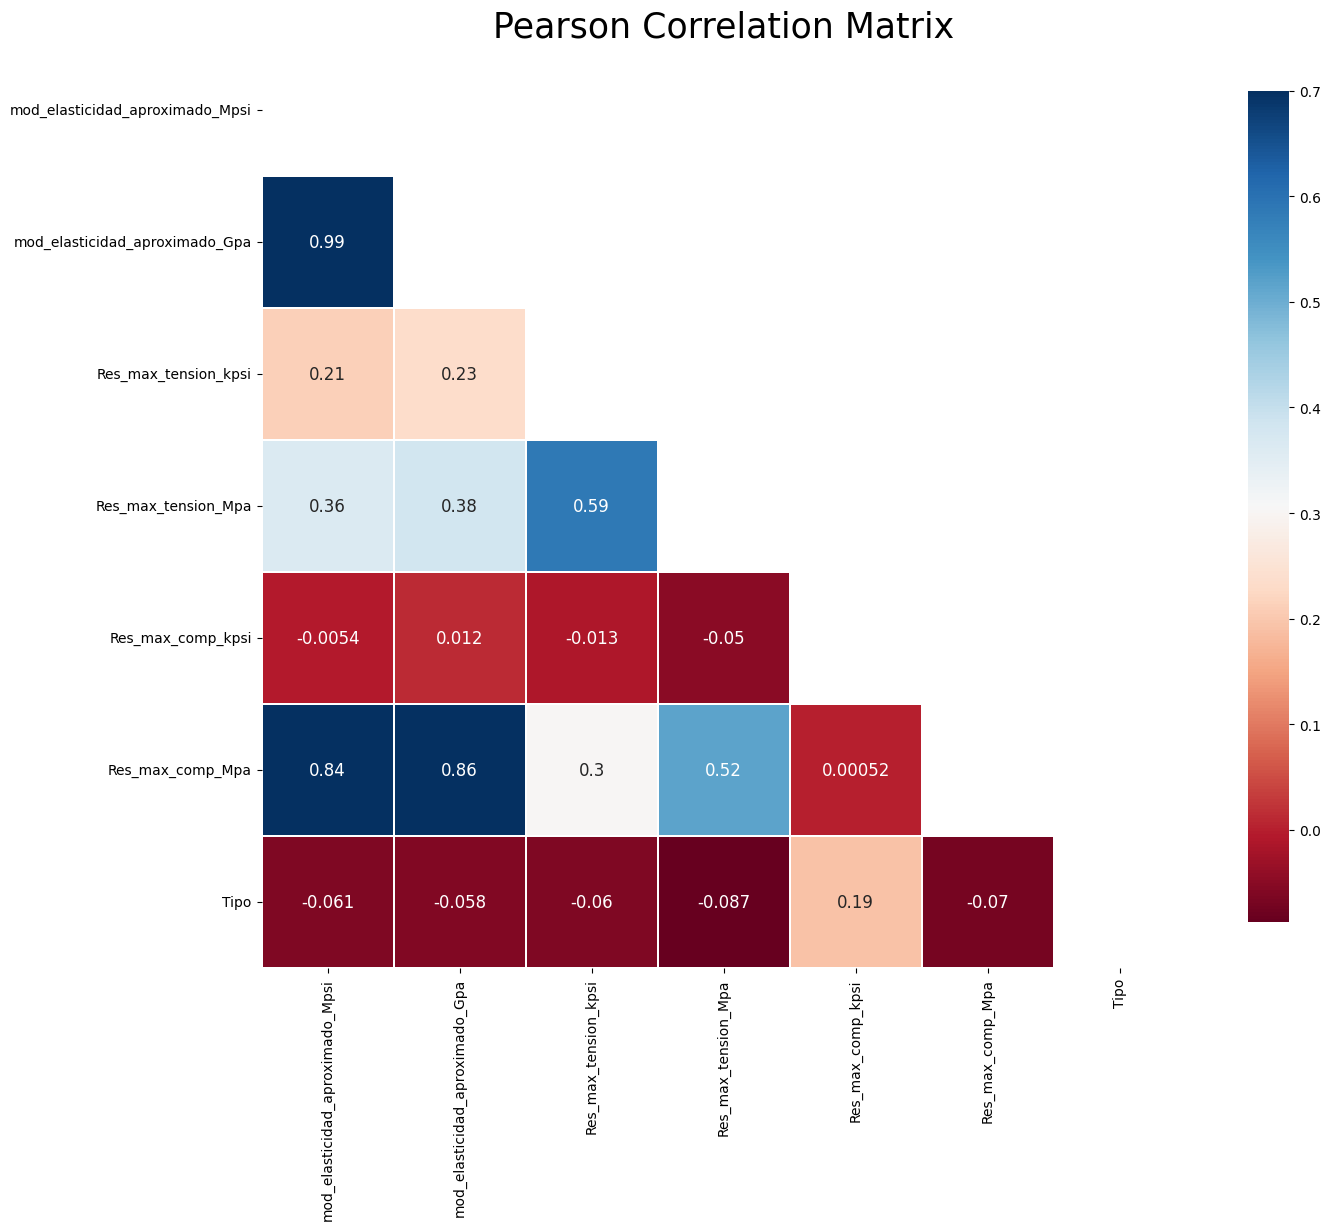

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('data_final.csv')


for col in data.columns:
     data[col] = pd.to_numeric(data[col], errors='coerce')
numerical_data = data.select_dtypes(include=[np.number])

mask = np.zeros_like(numerical_data.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(numerical_data.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="RdBu",
            linecolor='w',annot=True,annot_kws={"size":12},mask=mask,cbar_kws={"shrink": .9});

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework.ops import disable_eager_execution
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import graphviz

import random

In [ ]:
data = pd.read_csv('data_final.csv')
target_columns = ['mod_elasticidad_aproximado_Mpsi', 'mod_elasticidad_aproximado_Gpa']
X = data.drop(columns=target_columns).values
y = data[target_columns].values #variables objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.isnan(y_test).sum())

0


In [ ]:
X_train_numeric = np.where(X_train == '-', np.nan, X_train)
X_train_numeric = X_train_numeric.astype(np.float64)

mask = ~np.isnan(X_train_numeric).any(axis=1)
X_train_numeric = X_train_numeric[mask]
y_train = y_train[mask]
print(np.isnan(X_train_numeric).sum())

0


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') #rellenar valores faltantes en caso de existir con el promedio
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
hidden_layer_configurations = [
    (10),(10,10),(20),(30),(40), (50), (60), (64,32) , (100,), (200,), (300,),
    (100, 50), (200, 100), (300, 150),
    (100, 50, 25), (200, 100, 50), (300, 150, 75), (350,100), (400,100),(500,100),(1000),(1500),(2000), (3000)
]

results = []

for config in hidden_layer_configurations:

    model = MLPRegressor(hidden_layer_sizes=config, activation='relu', max_iter=2000, random_state=42)


    model.fit(X_train_scaled, y_train)


    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'hidden_layers': config,
        'MSE': mse,
        'R2': r2
    })

results_df = pd.DataFrame(results)


results_df.to_csv('results_gan.csv', sep=',', index=False)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Los resultados han sido guardados en 'results.csv'
